## Práctica 04
Crecimiento lineal de la estructura

----



In [ ]:
import camb
import numpy as np
import matplotlib.pyplot as plt


#### Ejercicio 1

Generar con CAMB el espectro de potencias lineal de la materia para un dado conjunto de parámetros cosmológicos.

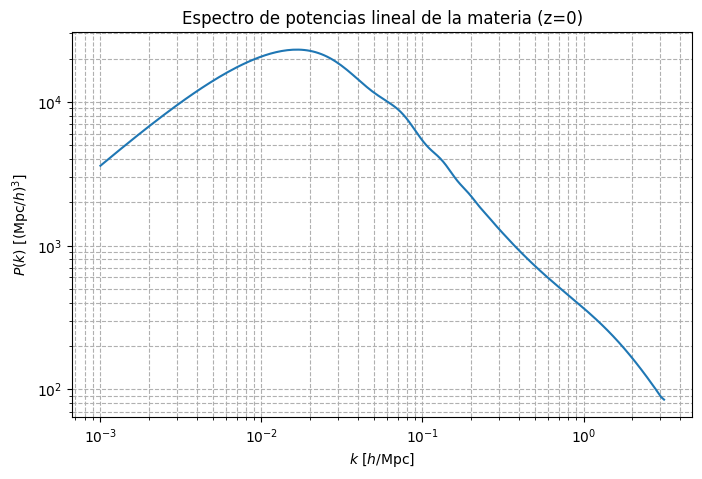

In [3]:

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_matter_power(redshifts=[0], kmax=2.0)
results = camb.get_results(pars)
k = np.logspace(-3, 0.5, 200)  # h/Mpc
PK = camb.get_matter_power_interpolator(pars, hubble_units=True, k_hunit=True, kmax=2.0)
pk = PK.P(0, k)  # z=0

plt.figure(figsize=(8,5))
plt.loglog(k, pk)
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]")
plt.title("Espectro de potencias lineal de la materia (z=0)")
plt.grid(True, which="both", ls="--")
plt.show()

#### Ejercicio 2

Cambiar $\Omega_m$ y ver como cambia el espectro. Verificar que el máximo se desplaza según lo discutido en la teoría. Variar $\Omega_m$ y $h$ tal que el producto se mantenga constante. Cómo cambia el espectro?

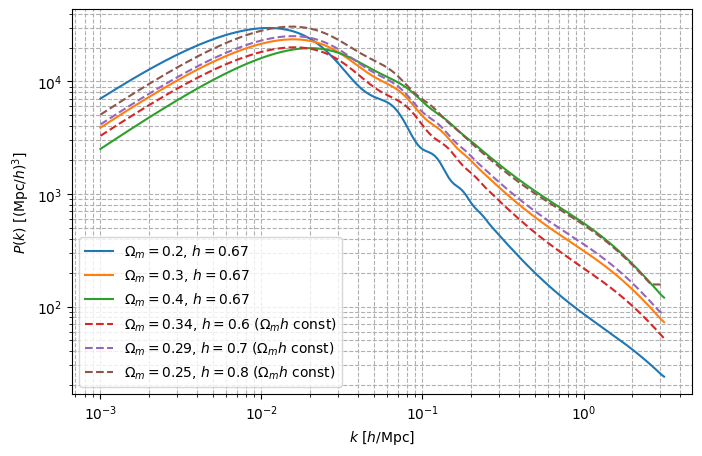

In [4]:
#init params:
h_fid = 0.67
Om_m_fid = 0.3
ombh2 = 0.022 #bariones * h^2
As = 2e-9
ns = 0.965

k = np.logspace(-3, 0.5, 200)  # h/Mpc

plt.figure(figsize=(8,5))

# vario Om_m y mantengo h
for Om_m in [0.2, 0.3, 0.4]:
    omch2 = Om_m * h_fid**2 - ombh2
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h_fid*100, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_matter_power(redshifts=[0], kmax=2.0)
    PK = camb.get_matter_power_interpolator(pars, hubble_units=True, k_hunit=True, kmax=2.0)
    pk = PK.P(0, k)
    plt.loglog(k, pk, label=fr"$\Omega_m={Om_m:.1f}$, $h={h_fid}$")

# mantengo Omega_m * h constante
Omh_fid = Om_m_fid * h_fid
for h in [0.6, 0.7, 0.8]:
    Om_m = Omh_fid / h
    omch2 = Om_m * h**2 - ombh2 #de dark matter *h**2
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_matter_power(redshifts=[0], kmax=2.0)
    PK = camb.get_matter_power_interpolator(pars, hubble_units=True, k_hunit=True, kmax=2.0)
    pk = PK.P(0, k)
    plt.loglog(k, pk, ls='--', label=fr"$\Omega_m={Om_m:.2f}$, $h={h}$ ($\Omega_m h$ const)")

plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


Al variar $\Omega_m$ manteniendo $h$ fijo, el máximo (el 'turn over') del espectro de potencias $P(k)$ se desplaza: para valores mayores de $\Omega_m$, el máximo se mueve hacia valores de $k$ mayores (escalas más pequeñas), y viceversa. Lo que controla el $k$ de equality es el producto; si se cambia un parámetro y se deja al otro fijo, el $k_{eq}$ será distinto.

Si se varía $\Omega_m$ y $h$ de modo que el producto $\Omega_m h$ se mantenga constante, la posición del máximo del espectro se mantiene maso menos fija (el espectro graficado está dividido por $h$); la amplitud y la forma pueden cambiar. La escala característica del espectro depende principalmente de $\Omega_m h$.

#### Ejercicio 3

Extraer la evolucion de $\delta_k$ dado un $k$, y graficar. Este ejercicio puede ser no trivial, así que habrá que investigar un poco cómo hacerlo (lo hice para la tesis jeje).


In [5]:
from classy import Class
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from matplotlib.lines import Line2D
import pandas as pd
def common_settings(k=0.01, omega_cdm=.25, A_s=2e-9, h=0.68): 
  """
  Set common settings for the CLASS simulation.
  Esto hace basicamente lo mismo que el diccionario de common_settings del principio (el de Julien),
    pero con los valores de k, omega_cdm, A_s y h como argumentos.

  Args:
    k (float): Value of k for the simulation.
    omega_cdm (float): Omega_cdm value for the simulation.
    A_s (float): A_s value for the simulation.
    h (float): h value for the simulation.

  Returns:
    A dictionary containing the common settings for the simulation.
  """
  _common_settings = {
    'output': 'mPk',
    'k_output_values': k,
    'h': h,
    'Omega_b': 0.3-omega_cdm,
    'Omega_cdm': omega_cdm,
    'A_s': A_s,
    'n_s': 0.9660499,
    'tau_reio': 0.05430842,
    'YHe': 0.2454,
    'compute damping scale': 'yes',
    'gauge': 'newtonian'
    }
  M = Class()
  M.set(_common_settings)
  M.compute()
  return M

def get_df_from_M(M): #tal vez lo modifique para obtener las derivadas directamente acá. sería útil para la grilla.
  """
  Extracts 'delta_cdm', 'a', and 'tau [Mpc]' vectors from the perturbations.
  It does not extract inputs of the perturbation dictionary (like A_s, h, omega...)

  Args:
    class: M - (example: common_settings(k=1)).

  Returns:
    A Pandas DataFrame containing the desired vectors.
  """
  all_k = M.get_perturbations()
  one_k = all_k['scalar'][0]
  a = one_k['a']
  tau = one_k['tau [Mpc]']
  delta_cdm = one_k['delta_cdm']
  delta_b = one_k['delta_b']
  df = pd.DataFrame({'tau [Mpc]': tau, 'a': a, 'delta_cdm': delta_cdm, 'delta_b': delta_b})
  return df

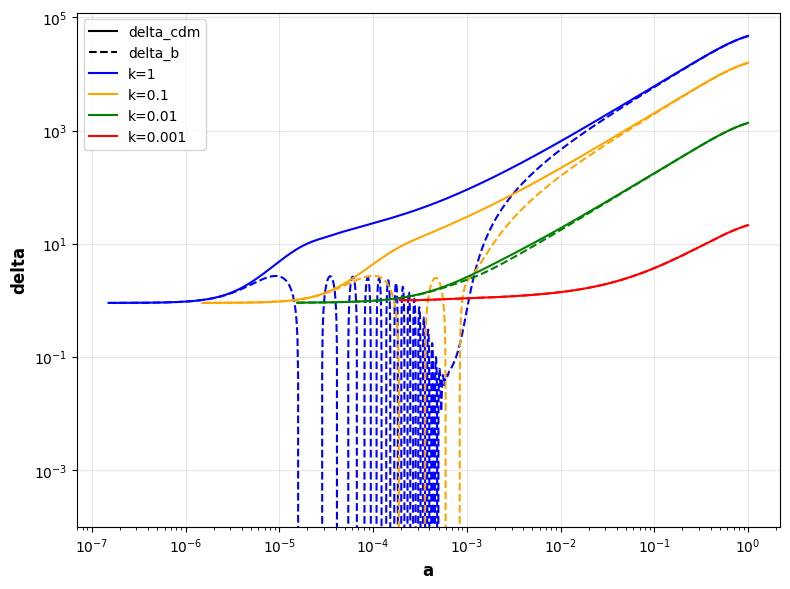

In [6]:
ks = [1, 0.1, 0.01, 0.001]
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

# legends lindas
line_style_elements = [
    Line2D([0], [0], color='black', linestyle='-', label='delta_cdm'),
    Line2D([0], [0], color='black', linestyle='--', label='delta_b')
]
color_elements = []

for i, k in enumerate(ks):
    M = common_settings(k)
    df = get_df_from_M(M)
    color = colors[i]

    ax.plot(df['a'], -df['delta_cdm'], linestyle='-', color=color)
    ax.plot(df['a'], -df['delta_b'], linestyle='--', color=color)
    color_elements.append(Line2D([0], [0], color=color, linestyle='-', label=f'k={k}'))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('delta', fontweight='bold', fontsize=12)
ax.set_xlabel('a', fontweight='bold', fontsize=12)
ax.grid(alpha=0.3)

ax.legend(handles=line_style_elements + color_elements)

plt.tight_layout()
plt.show()

$\delta_m = \Omega_b/\Omega_m * \delta_b + \Omega_{cdm}/\Omega_m * \delta_{cdm}$. Por separado se ven algunos modos con BAOS y otros no

#### Ejercicio 4

Obtener el factor de crecimiento, y ver cómo cambia al cambiar parámetros cosmológicos. De cuales depende más?

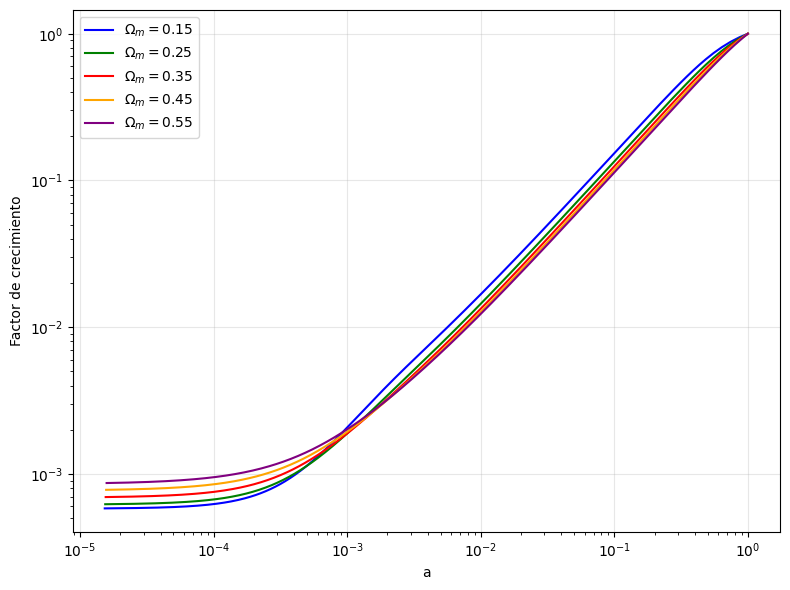

In [1]:
from classy import Class
import matplotlib.pyplot as plt
import numpy as np

def get_growth_factor_CLASS(omega_cdm=0.25, omega_b=0.05, h=0.67, A_s=2e-9, n_s=0.965, k=0.01):
    params = {
        'output': 'mPk, vTk, dTk',
        'h': h,
        'Omega_b': omega_b,
        'Omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': 0.054,
        'k_output_values': k,
        'gauge': 'newtonian'
    }
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    pert = cosmo.get_perturbations()
    a = pert['scalar'][0]['a']
    delta_cdm = pert['scalar'][0]['delta_cdm']
    growth = np.array(delta_cdm) / delta_cdm[-1] #normalizo a(hoy)=1
    cosmo.struct_cleanup()
    cosmo.empty()
    return a, growth

plt.figure(figsize=(8,6))
for omega_cdm, color in zip([.1*i for i in range(1,6)], ['blue', 'green', 'red', 'orange', 'purple']):
    a, growth = get_growth_factor_CLASS(omega_cdm=omega_cdm, omega_b=0.05, h=0.67)
    plt.plot(a, growth, label=fr'$\Omega_m={omega_cdm+0.05:.2f}$', color=color)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('a')
plt.ylabel('Factor de crecimiento')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

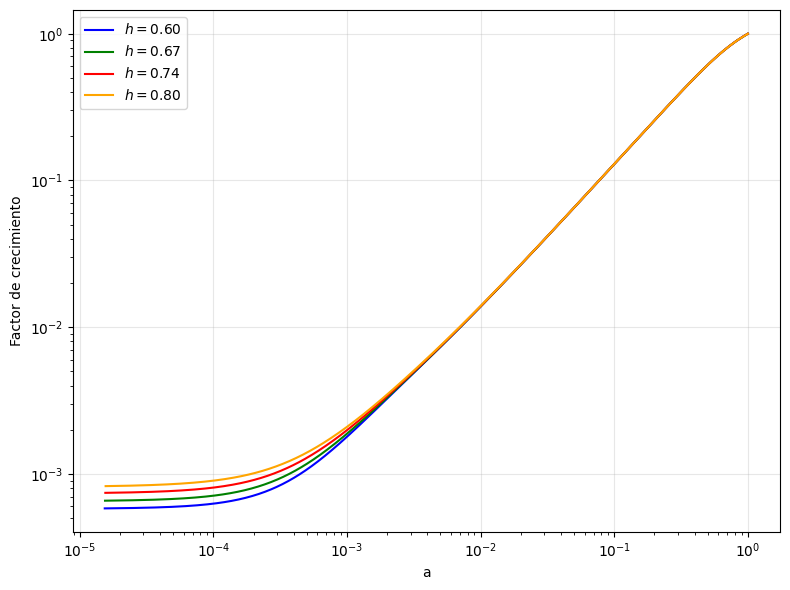

: 

In [ ]:
#lo mismo pero variando h
plt.figure(figsize=(8,6))
for h, color in zip([0.6, 0.67, 0.74, 0.8], ['blue', 'green', 'red', 'orange']):
    a, growth = get_growth_factor_CLASS(omega_cdm=0.25, omega_b=0.05, h=h)
    plt.plot(a, growth, label=fr'$h={h:.2f}$', color=color)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('a')
plt.ylabel('Factor de crecimiento')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Cuando varíamos $\Omega_m$ afecta más; variar h y mantener \Omega_m fijo afecta hasta, aproximadamente, equality. Cuando empieza a dominar la materia claramente afecta más la variación en este parámetro.

#### Ejercicio 5

Obtener la función de transferencia, y ver cómo cambia al cambiar parámetros cosmológicos. De cuales depende más?

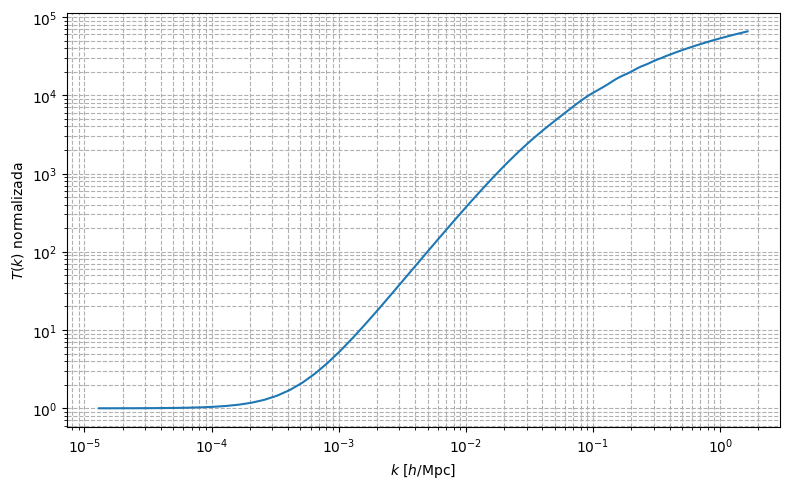

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class

def plot_transfer_function(omega_cdm=0.22, omega_b=0.022, h=0.67, A_s=2e-9, n_s=0.965):
    params = {
        'output': 'mTk',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': 0.054,
        'z_pk': 0.0,
        'gauge': 'newtonian'
    }
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    transfer = cosmo.get_transfer()
    k_out = np.array(transfer['k (h/Mpc)'])
    Tk = np.array(transfer['d_cdm'])
    Tk_norm = Tk / Tk[0]
    plt.figure(figsize=(8,5))
    plt.loglog(k_out, Tk_norm)
    plt.xlabel(r"$k$ [$h$/Mpc]")
    plt.ylabel(r"$T(k)$ normalizada")
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
    cosmo.struct_cleanup()
    cosmo.empty()

plot_transfer_function()

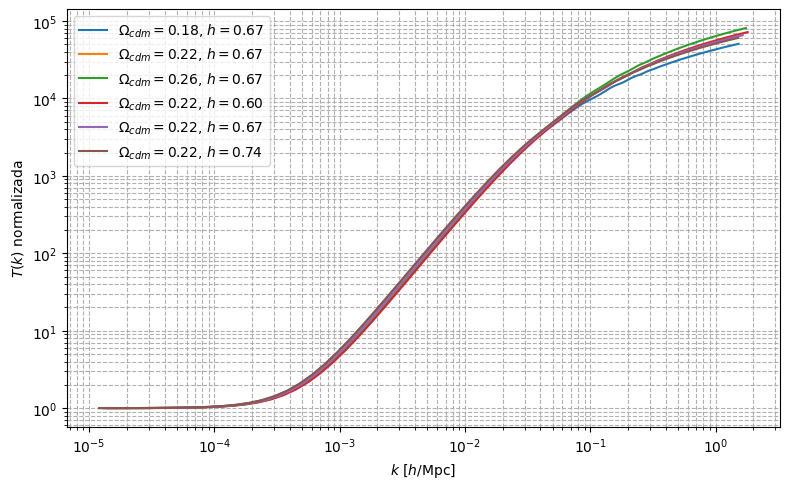

In [ ]:
def plot_transfer_function(omega_cdm=0.22, omega_b=0.022, h=0.67, A_s=2e-9, n_s=0.965, ax=None, label=None):
    params = {
        'output': 'mTk',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': 0.054,
        'z_pk': 0.0,
        'gauge': 'newtonian'
    }
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    transfer = cosmo.get_transfer()
    k_out = np.array(transfer['k (h/Mpc)'])
    Tk = np.array(transfer['d_cdm'])
    Tk_norm = Tk / Tk[0]
    if ax is None:
        plt.figure(figsize=(8,5))
        plt.loglog(k_out, Tk_norm, label=label)
        plt.xlabel(r"$k$ [$h$/Mpc]")
        plt.ylabel(r"$T(k)$ normalizada")
        plt.grid(True, which="both", ls="--")
        plt.tight_layout()
        plt.show()
    else:
        ax.loglog(k_out, Tk_norm, label=label)
    cosmo.struct_cleanup()
    cosmo.empty()

omega_cdms = [0.18, 0.22, 0.26]
hs = [0.60, 0.67, 0.74]

fig, ax = plt.subplots(figsize=(8,5))

# vario omega_cdm, h fijo
for omega_cdm in omega_cdms:
    plot_transfer_function(omega_cdm=omega_cdm, h=0.67, ax=ax, label=fr"$\Omega_{{cdm}}={omega_cdm:.2f}$, $h=0.67$")

# vario h, omega_cdm fijo
for h in hs:
    plot_transfer_function(omega_cdm=0.22, h=h, ax=ax, label=fr"$\Omega_{{cdm}}=0.22$, $h={h:.2f}$")

ax.set_xlabel(r"$k$ [$h$/Mpc]")
ax.set_ylabel(r"$T(k)$ normalizada")
ax.grid(True, which="both", ls="--")
ax.legend()
plt.tight_layout()
plt.show()

también depende más de Omega_m que de h

#### Ejercicio 6

El CAMB permite elegir modelos de crecimiento no lineal de las estructuras. Genere con el CAMB el $P(k)$ no lineal según distintos modelos, y compare con el espectro lineal.

Grafique a distintos redshifts, y compruebe que la escala donde son importantes las no linealidades se hace más grande a medida que aumenta el tiempo (redshifts más bajos).

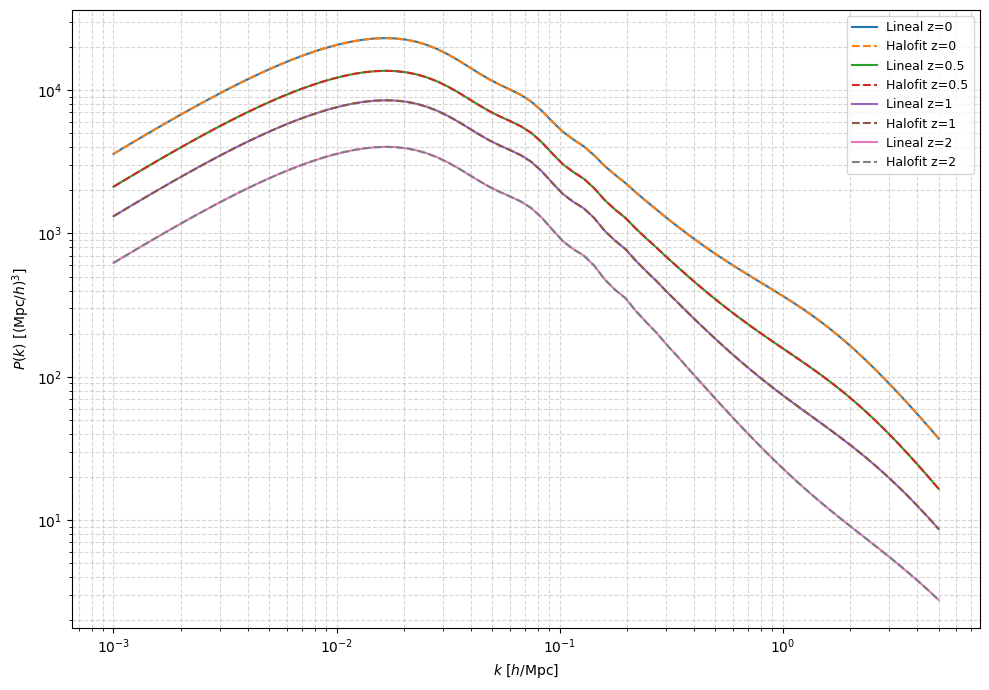

In [9]:
import camb
import numpy as np
import matplotlib.pyplot as plt

H0 = 67.5
ombh2 = 0.022
omch2 = 0.122
As = 2e-9
ns = 0.965

k = np.logspace(-3, 0.7, 80)  # h/Mpc
redshifts = [0, 0.5, 1, 2]
nonlinear_models = ['None', 'Halofit']

plt.figure(figsize=(10, 7))

for z in redshifts:
    for model, ls in zip(nonlinear_models, ['-', '--']):
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
        pars.InitPower.set_params(As=As, ns=ns)
        pars.set_matter_power(redshifts=[z], kmax=5.0)
        if model == 'None':
            pars.NonLinear = camb.model.NonLinear_none
        elif model == 'Halofit':
            pars.NonLinear = camb.model.NonLinear_both

        PK = camb.get_matter_power_interpolator(pars, nonlinear=True, hubble_units=True, k_hunit=True, kmax=5.0)
        pk = PK.P(z, k)
        label = f"{model} z={z}" if model != 'None' else f"Lineal z={z}"
        plt.loglog(k, pk, ls=ls, label=label)

plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]")
plt.legend(fontsize=9)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


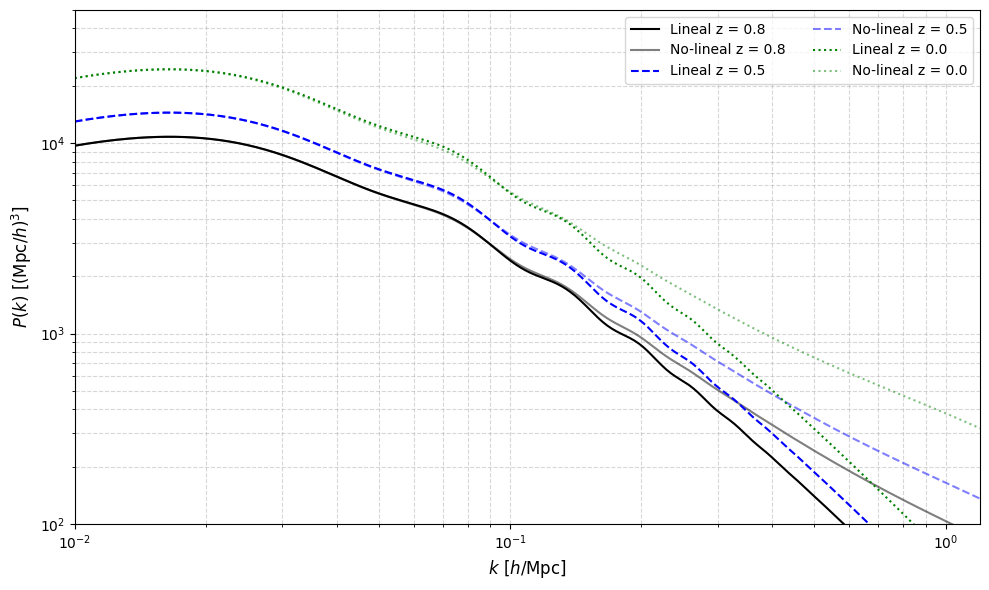

In [ ]:
def plot_linear_nonlinear_pk(
    H0=67.4, ombh2=0.022, omch2=0.120, mnu=0.06, tau=0.054,
    As=2.1e-9, ns=0.965, redshifts=[0, 0.5, 0.8],
    kmin=1e-2, kmax=1.2, npoints=200
):


    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_matter_power(redshifts=redshifts, kmax=2.0, nonlinear=False)

    # lineal 
    pars.NonLinear = camb.model.NonLinear_none
    results_lin = camb.get_results(pars)
    kh_lin, z_lin, pk_lin = results_lin.get_matter_power_spectrum(
        minkh=kmin, maxkh=kmax, npoints=npoints
    )

    #  no lineal
    pars.NonLinear = camb.model.NonLinear_both
    pars.set_matter_power(redshifts=redshifts, kmax=1.2, nonlinear=True)
    results_nonlin = camb.get_results(pars)
    results_nonlin.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results_nonlin.get_matter_power_spectrum(
        minkh=kmin, maxkh=kmax, npoints=npoints
    )

    # plot
    plt.figure(figsize=(10, 6))
    colors = ['k', 'b', 'g']
    linestyles = ['-', '--', ':']

    for i, (redshift, color, ls) in enumerate(zip(z_lin, colors, linestyles)):
        idx = len(z_lin)-1-i
        z_label = f'z = {z_lin[idx]:.1f}'
        plt.loglog(kh_lin, pk_lin[idx,:], color=color, ls=ls, label=f'Lineal {z_label}')
        plt.loglog(kh_nonlin, pk_nonlin[idx,:], color=color, ls=ls, alpha=0.5, label=f'No-lineal {z_label}')

    plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=12)
    plt.ylabel(r'$P(k)\ [(\mathrm{Mpc}/h)^3]$', fontsize=12)
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.legend(ncol=2, fontsize=10)
    plt.xlim(kmin, kmax)
    plt.ylim(1e2, 5e4)
    plt.tight_layout()
    plt.show()

plot_linear_nonlinear_pk()